In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from ast import literal_eval
from itertools import chain
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [2]:
train = pd.read_csv('nbme/train.csv')
test = pd.read_csv('nbme/test.csv')
patient_notes = pd.read_csv('nbme/patient_notes.csv')
features = pd.read_csv('nbme/features.csv')

In [3]:
# Importing patient Notes Data 
print(patient_notes.shape)
print(patient_notes.nunique())
patient_notes.head()

(42146, 3)
pn_num        42146
case_num         10
pn_history    42146
dtype: int64


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [4]:
# Importing Features Data Representing different kind of features for each clinical case 
print(features.shape)
print(features.nunique())
features.head()

(143, 3)
feature_num     143
case_num         10
feature_text    131
dtype: int64


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [5]:
# Importing train Data (Each row represent a Unique Identifier for Patient-Feature Pair)
print(train.shape)
print(train.nunique())
train.head()

(14300, 6)
id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [6]:
# Assuming 'train' is your DataFrame
null_count = train.isnull().sum().sum()
print("Total number of observations with null values:", null_count)

Total number of observations with null values: 0


In [7]:
print("Number of Empty annotions and locations = ", sum(train["location"] == '[]'))

Number of Empty annotions and locations =  4399


In [8]:
#value counts
temp = patient_notes.groupby('case_num').count()['pn_history'].reset_index().sort_values(by='pn_history', ascending=False)
temp.style.background_gradient(cmap='Purples')

,case_num,pn_history
3,3,9753
5,5,6909
4,4,5405
9,9,5151
8,8,4196
7,7,4101
0,0,2268
2,2,1958
6,6,1597
1,1,808


<Axes: xlabel='case_num', ylabel='count'>

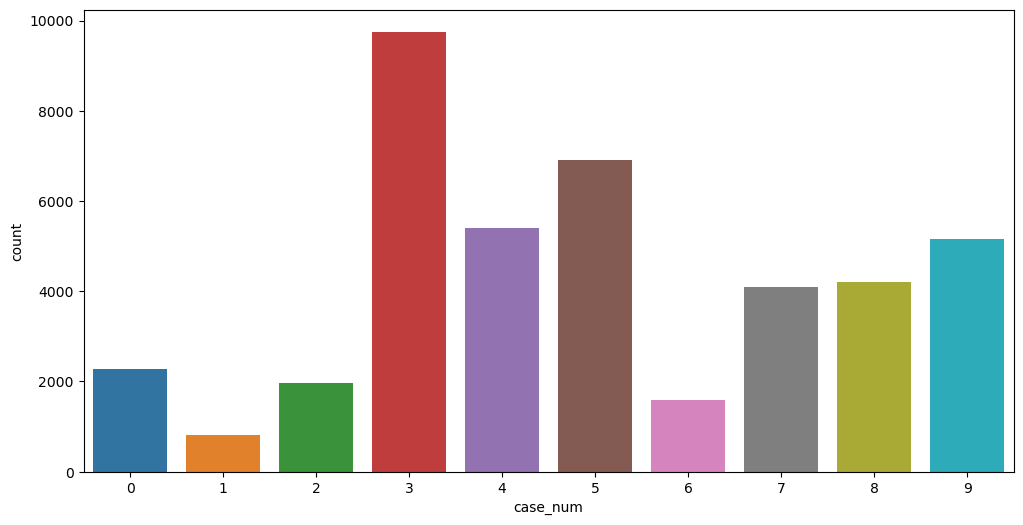

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='case_num', data=patient_notes)

In [10]:
#Most common word in the target Selected
patient_notes['temp']= patient_notes['pn_history'].apply(lambda x: str(x).split())
top= Counter([item for sublist in patient_notes['temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns=["Common_words", 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,and,134345
1,with,95369
2,of,92239
3,no,82617
4,a,75820
5,the,70754
6,in,70346
7,has,68659
8,is,62703
9,for,57314


In [11]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
patient_notes['temp'] = patient_notes['temp'].apply(lambda x: remove_stopword(x))

In [12]:
top = Counter([item for sublist in patient_notes['temp'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp=temp.iloc[1:,:]
temp.columns=["Common_words",'count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,pain,40083
2,2,38697
3,No,35750
4,none,33490
5,denies,30296
6,-,22866
7,last,22159
8,3,21139
9,weeks,20609
10,PMH:,19741


In [13]:
most_popular_case = patient_notes[patient_notes['case_num']==3]

In [14]:
#Most common  words in 
top = Counter([item for sublist in most_popular_case['temp'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,pain,26939
1,2,13638
2,He,13548
3,No,9174
4,back,7629
5,35,7509
6,epigastric,6950
7,none,6402
8,pain.,6201
9,denies,6157


In [15]:
# if n_words=1 -> unigrams, if n_words=2 -> bigrams..
def get_top_Nwords(corpus, n=None, remove_stop_words=False, n_words=1):
    if remove_stop_words:
        vec = CountVectorizer(stop_words='english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    
    bag_ofWords =vec.transform(corpus)
    sum_words = bag_ofWords.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
common_words = get_top_Nwords(patient_notes['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

sexually active 16461
weeks ago 14173
chest pain 12695
months ago 11170
drug use 10382
ros negative 9517
pmh psh 8969
year old 8922
nausea vomiting 6939
35 yo 6192
abdominal pain 6062
allergies nkda 5925
past weeks 5523
years ago 5377
weight loss 5272
falling asleep 5148
epigastric pain 5012
old female 4676
breast cancer 4672
active boyfriend 4612


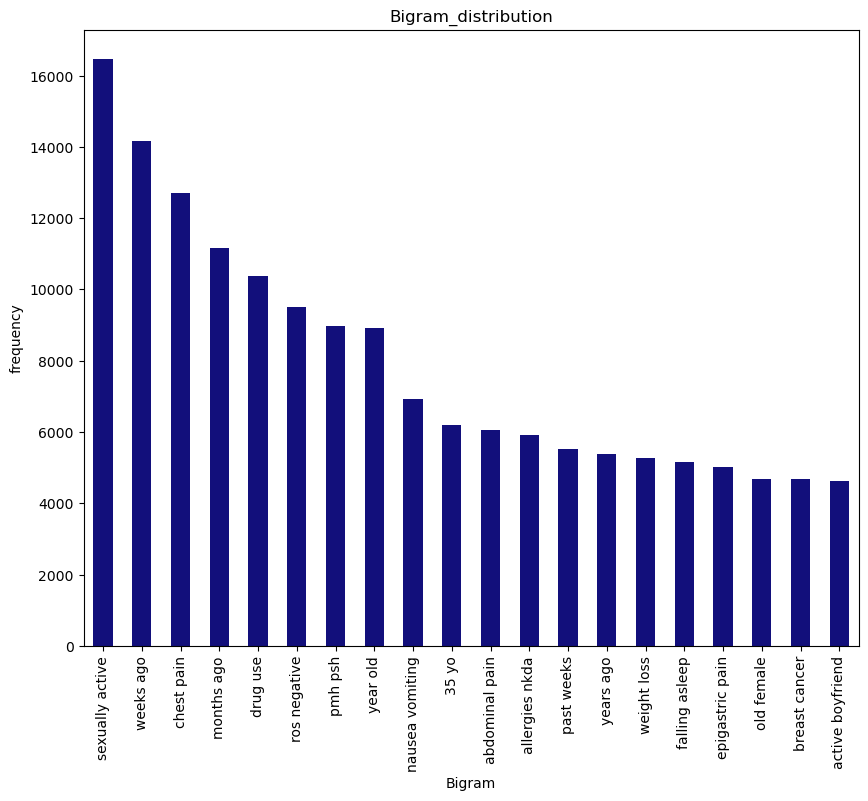

In [17]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Bigram_distribution")
ax1.set_xlabel('Bigram')
ax1.set_ylabel("frequency")
plt.show()

In [18]:
common_words = get_top_Nwords(patient_notes['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

year old female 4388
sexually active boyfriend 4242
illicit drug use 3540
uncle bleeding ulcer 3413
ros negative pmh 3362
sexually active husband 2878
35 year old 2872
difficulty falling asleep 2853
pmh psh meds 2584
lmp weeks ago 2265
year old male 2173
chest pain sob 1990
use sexually active 1947
drugs sexually active 1893
fh uncle bleeding 1788
denies chest pain 1781
pmh psh fh 1745
15 30 minutes 1657
drug use sexually 1607
mr hamilton 35 1476


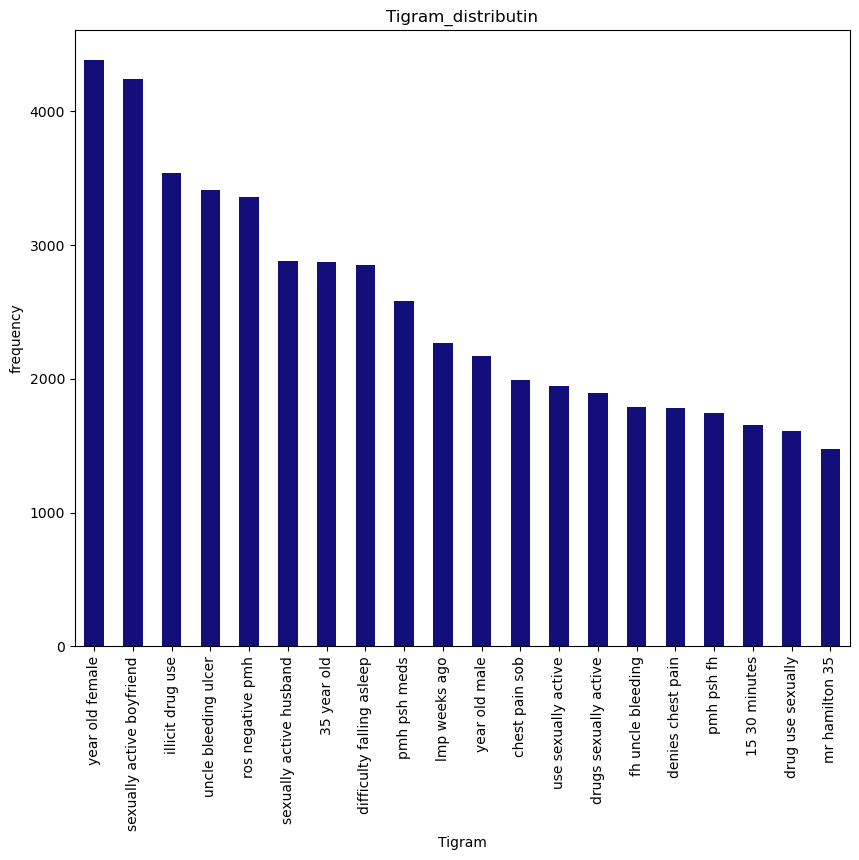

In [19]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Tigram_distributin")
ax1.set_xlabel('Tigram')
ax1.set_ylabel("frequency")
plt.show()

In [20]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Download NLTK resources (only required if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load datasets
patient_notes = pd.read_csv('nbme/patient_notes.csv')
features = pd.read_csv('nbme/features.csv')
train= pd.read_csv('nbme/train.csv')

# Tokenization
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Text normalization
def normalize_text(tokens):
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    return tokens

# Lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

# Preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = tokenize_text(text)
    
    # Text normalization
    normalized_tokens = normalize_text(tokens)
    
    # Lemmatization
    lemmatized_tokens = lemmatize_text(normalized_tokens)
    
    # Remove stopwords
    cleaned_tokens = remove_stopwords(lemmatized_tokens)
    
    # Join tokens back into a string
    processed_text = ' '.join(cleaned_tokens)
    
    return processed_text

# Apply preprocessing to 'pn_history' column in patient_notes DataFrame
patient_notes['pn_history'] = patient_notes['pn_history'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gouthami\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gouthami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gouthami\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
from collections import Counter
import re

# Text length analysis (number of words per entry)
patient_notes['word_count'] = patient_notes['pn_history'].apply(lambda x: len(x.split()))

# Basic text processing to identify common terms - lowercasing and simple tokenization
# For the purpose of a basic analysis, let's consider words longer than 3 characters to reduce common English stop words
tokens = [word for pn in patient_notes['pn_history'] for word in re.findall(r'\b\w{4,}\b', pn.lower())]

# Count the frequency of each token
token_freq = Counter(tokens)

# Most common terms (excluding common English stop words might be needed for more accurate medical term frequency)
common_terms = token_freq.most_common(20)

# Summary statistics for word counts
word_count_summary = patient_notes['word_count'].describe()
print(word_count_summary)

count    42146.000000
mean        95.018958
std         15.837490
min          7.000000
25%         86.000000
50%         98.000000
75%        106.000000
max        138.000000
Name: word_count, dtype: float64


In [22]:
common_terms

[('pain', 79884),
 ('none', 58633),
 ('week', 54337),
 ('denies', 52132),
 ('change', 39250),
 ('year', 35570),
 ('month', 33890),
 ('last', 28459),
 ('episode', 24938),
 ('drug', 24426),
 ('patient', 23284),
 ('past', 21655),
 ('nausea', 19683),
 ('allergy', 19129),
 ('period', 19103),
 ('active', 18780),
 ('headache', 18605),
 ('time', 18533),
 ('history', 18374),
 ('report', 18235)]

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare text data for topic modeling
text_data = patient_notes['pn_history'].values

# Initialize TF-IDF Vectorizer to convert the text data into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the text data
tfidf = tfidf_vectorizer.fit_transform(text_data)

# Initialize and fit Latent Dirichlet Allocation (LDA) model for topic modeling
# Let's start with identifying 5 topics for simplicity
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)

lda.fit(tfidf)

# Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d" % (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_dict

no_top_words = 10
topic_dict = display_topics(lda, tfidf_vectorizer.get_feature_names_out(), no_top_words)

topic_dict

{'Topic 0': ['episode',
  'palpitation',
  'ago',
  'week',
  'ha',
  'denies',
  'heart',
  'change',
  'nervousness',
  'job'],
 'Topic 1': ['period',
  'month',
  'day',
  'irregular',
  'heavy',
  'year',
  'cancer',
  'ago',
  'wa',
  'ha'],
 'Topic 2': ['headache',
  'pain',
  'ha',
  'yesterday',
  'ibuprofen',
  'tylenol',
  'migraine',
  'dull',
  'constant',
  'head'],
 'Topic 3': ['pain',
  'tum',
  'stool',
  'motrin',
  'ha',
  'epigastric',
  'uncle',
  'ulcer',
  'construction',
  'burning'],
 'Topic 4': ['son',
  'htn',
  'ha',
  'asleep',
  'sleeping',
  'ambien',
  '67',
  'trouble',
  'sleep',
  'lisinopril']}

In [24]:
# Simplified Named Entity Recognition (NER) Analysis
# Identifying common medical entities such as conditions, treatments, and body parts

# Lists of keywords for different categories (simplified example, not exhaustive)
conditions_keywords = ['pain', 'nausea', 'fever', 'cough', 'headache', 'dizziness', 'fatigue']
treatments_keywords = ['medication', 'surgery', 'therapy', 'treatment', 'injection']
body_parts_keywords = ['head', 'chest', 'abdomen', 'leg', 'arm', 'back', 'neck']

# Function to count occurrences of keywords in patient notes
def count_keywords(text, keywords):
    count = sum(text.lower().count(keyword) for keyword in keywords)
    return count

# Count occurrences for each category
patient_notes['conditions'] = patient_notes['pn_history'].apply(count_keywords, keywords=conditions_keywords)
patient_notes['treatments'] = patient_notes['pn_history'].apply(count_keywords, keywords=treatments_keywords)
patient_notes['body_parts'] = patient_notes['pn_history'].apply(count_keywords, keywords=body_parts_keywords)

# Summarize the counts
summary_counts = {
    'conditions_total': patient_notes['conditions'].sum(),
    'treatments_total': patient_notes['treatments'].sum(),
    'body_parts_total': patient_notes['body_parts'].sum()
}

summary_counts

{'conditions_total': 149611,
 'treatments_total': 13722,
 'body_parts_total': 64397}

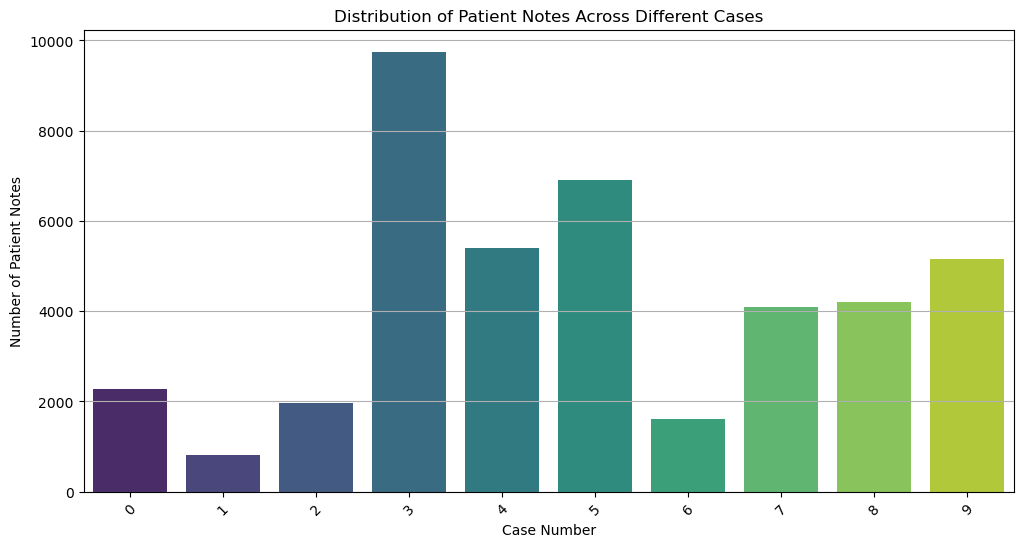

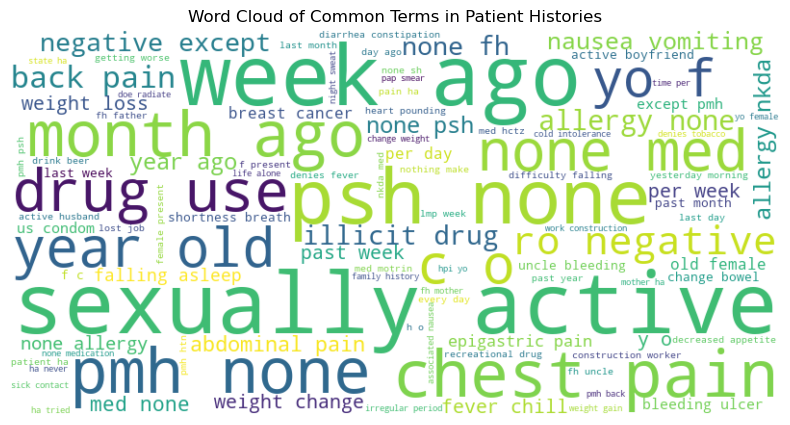

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trend Analysis Over Cases
case_distribution = patient_notes['case_num'].value_counts().sort_index()

# Data Visualization of Case Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=case_distribution.index, y=case_distribution.values, palette='viridis')
plt.title('Distribution of Patient Notes Across Different Cases')
plt.xlabel('Case Number')
plt.ylabel('Number of Patient Notes')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

# Additional Visualization: Word Cloud for Common Terms
from wordcloud import WordCloud

# Combine all patient notes into a single text for word cloud generation
all_text = ' '.join(patient_notes['pn_history'])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.title('Word Cloud of Common Terms in Patient Histories')
plt.show()

In [26]:
# Aggregate patient notes by case number
case_texts = patient_notes.groupby('case_num')['pn_history'].apply(lambda x: ' '.join(x)).reset_index()

# Define a function to find the most frequent terms for each case
def find_frequent_terms(text, n=5):
    words = re.findall(r'\b\w{4,}\b', text.lower())  # Extract words with 4 or more characters
    freq_dist = Counter(words)
    common_terms = freq_dist.most_common(n)
    return [term for term, freq in common_terms]

# Apply the function to each case's aggregated text
case_texts['frequent_terms'] = case_texts['pn_history'].apply(find_frequent_terms)

# Display the frequent terms for each case number to infer context
case_contexts = case_texts[['case_num', 'frequent_terms']]
case_contexts

,case_num,frequent_terms
0,0,"[episode, heart, none, month, denies]"
1,1,"[pain, none, month, last, ibuprofen]"
2,2,"[period, year, last, irregular, change]"
3,3,"[pain, week, none, denies, stool]"
4,4,"[week, denies, none, nervousness, change]"
5,5,"[none, episode, week, palpitation, denies]"
6,6,"[pain, asthma, chest, albuterol, denies]"
7,7,"[period, month, none, last, change]"
8,8,"[week, denies, sleep, asleep, sleeping]"
9,9,"[headache, pain, none, yesterday, denies]"
